# Modelling - Regression

In this notebook, I perform regression on each cluster (as determined from previous notebook) to determine the best price for each cluster. 

**Contents:**
- [Imports](#Import-libraries-and-data)
- [Preprocessing](#Preprocessing)
- [Linear Regression](#Linear-Regression)
- [Ridge](#Data-exploration)
- [Lasso](#Preprocessing)
- [eNet](#Preprocessing)
- [References](#References)

### Import libraries and data

In [51]:
#import libraries
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

# imports for preprocessing
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from mlxtend.feature_selection import SequentialFeatureSelector

# imports for modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.pipeline import Pipeline

%matplotlib inline

In [31]:
#read data
trx = pd.read_csv("../data/trx_clustered.csv")
print("=================== Top 5 rows of dataset ===================")
display(trx.head())
print("=================== Shape of dataset ===================")
print(trx.shape)
print("=================== Data types in dataset ===================")
print(trx.dtypes)
print("=================== Description of data in dataset ===================")
display(trx.describe())

=================== Top 5 rows of dataset ===================


,sales,profit,shipping_cost,unit_price,monetary_value,quantity,discount,heavy_discount,heavy_discount_regions,non_profitable,non_profitable_regions,more_qty,more_qty_regions,recency,frequency,category_Furniture,category_Office Supplies,category_Technology,ship_mode_First Class,ship_mode_Same Day,ship_mode_Second Class,ship_mode_Standard Class,region_Canada,region_Caribbean,region_Central Africa,region_Central America,region_Central Asia,region_Central US,region_Eastern Africa,region_Eastern Asia,region_Eastern Europe,region_Eastern US,region_North Africa,region_Northern Europe,region_Oceania,region_South America,region_Southeastern Asia,region_Southern Africa,region_Southern Asia,region_Southern Europe,region_Southern US,region_Western Africa,region_Western Asia,region_Western Europe,region_Western US,segment_Consumer,segment_Corporate,segment_Home Office,market_Africa,market_Asia Pacific,market_Europe,market_LATAM,market_USCA,order_priority_Critical,order_priority_High,order_priority_Low,order_priority_Medium,cluster
0,221.980,62.1544,40.77,110.990,24644.6275,2,0.0,0,0,0,0,0,1,16,89,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1
1,341.960,54.7136,25.27,170.980,24644.6275,2,0.0,0,0,0,0,0,1,16,89,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1
2,48.712,5.4801,11.13,48.712,24644.6275,1,0.2,0,0,0,0,0,1,16,89,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1
3,17.940,4.6644,4.29,5.980,24644.6275,3,0.0,0,0,0,0,1,1,16,89,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0
4,12.624,-2.5248,1.97,6.312,24644.6275,2,0.2,0,0,1,0,0,1,16,89,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1


=================== Shape of dataset ===================
(48575, 58)
=================== Data types in dataset ===================
sales                       float64
profit                      float64
shipping_cost               float64
unit_price                  float64
monetary_value              float64
quantity                      int64
discount                    float64
heavy_discount                int64
heavy_discount_regions        int64
non_profitable                int64
non_profitable_regions        int64
more_qty                      int64
more_qty_regions              int64
recency                       int64
frequency                     int64
category_Furniture            int64
category_Office Supplies      int64
category_Technology           int64
ship_mode_First Class         int64
ship_mode_Same Day            int64
ship_mode_Second Class        int64
ship_mode_Standard Class      int64
region_Canada                 int64
region_Caribbean              int64
regio

,sales,profit,shipping_cost,unit_price,monetary_value,quantity,discount,heavy_discount,heavy_discount_regions,non_profitable,non_profitable_regions,more_qty,more_qty_regions,recency,frequency,category_Furniture,category_Office Supplies,category_Technology,ship_mode_First Class,ship_mode_Same Day,ship_mode_Second Class,ship_mode_Standard Class,region_Canada,region_Caribbean,region_Central Africa,region_Central America,region_Central Asia,region_Central US,region_Eastern Africa,region_Eastern Asia,region_Eastern Europe,region_Eastern US,region_North Africa,region_Northern Europe,region_Oceania,region_South America,region_Southeastern Asia,region_Southern Africa,region_Southern Asia,region_Southern Europe,region_Southern US,region_Western Africa,region_Western Asia,region_Western Europe,region_Western US,segment_Consumer,segment_Corporate,segment_Home Office,market_Africa,market_Asia Pacific,market_Europe,market_LATAM,market_USCA,order_priority_Critical,order_priority_High,order_priority_Low,order_priority_Medium,cluster
count,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.00000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000,48575.000000
mean,174.368493,18.852732,18.063502,55.579586,16390.883834,3.404653,0.143860,0.211282,0.080535,0.246217,0.080535,0.567844,0.865322,22.697581,67.211920,0.18244,0.628924,0.188636,0.144375,0.051302,0.200329,0.603994,0.007617,0.033742,0.012393,0.111539,0.004179,0.045805,0.014267,0.044900,0.029665,0.055708,0.025095,0.042738,0.067092,0.059002,0.060566,0.009038,0.050232,0.041132,0.031909,0.028224,0.048132,0.113495,0.063531,0.517694,0.301204,0.181101,0.089017,0.275100,0.227030,0.204282,0.204570,0.073248,0.301245,0.047597,0.577910,0.529038
std,241.611565,80.216722,27.504931,70.156956,5015.224749,2.218692,0.212889,0.408222,0.272123,0.430811,0.272123,0.495381,0.341383,25.670098,13.389054,0.38621,0.483098,0.391223,0.351473,0.220616,0.400251,0.489071,0.086944,0.180565,0.110634,0.314801,0.064511,0.209065,0.118589,0.207086,0.169664,0.229359,0.156416,0.202268,0.250184,0.235630,0.238535,0.094637,0.218425,0.198598,0.175761,0.165615,0.214047,0.317200,0.243917,0.499692,0.458786,0.385106,0.284771,0.446569,0.418917,0.403180,0.403391,0.260545,0.458804,0.212913,0.493898,0.640497
min,0.444000,-493.320000,1.002000,0.336000,1401.690240,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.280000,0.000000,2.470000,11.340000,12849.128500,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,58.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,77.670000,8.640000,7.100000,27.270000,15710.884260,3.000000,0.000000

### Preprocessing
I standardize the features so that the coefficients of the regression are interpretable. Regression works best on normally distributed variables so I will perform box-cox transformation on these features as well. 

In [32]:
# separate numerical from categorical variables since standardization is relevant for continuous variables
trx_num = trx[trx.columns[:7]]
trx_cat = trx[trx.columns[7:]]
# display 
print("=================== Top 5 rows of numerical dataset ===================")
display(trx_num.head())
print("=================== Top 5 rows of categorical dataset ===================")
display(trx_cat.head())

=================== Top 5 rows of numerical dataset ===================


,sales,profit,shipping_cost,unit_price,monetary_value,quantity,discount
0,221.980,62.1544,40.77,110.990,24644.6275,2,0.0
1,341.960,54.7136,25.27,170.980,24644.6275,2,0.0
2,48.712,5.4801,11.13,48.712,24644.6275,1,0.2
3,17.940,4.6644,4.29,5.980,24644.6275,3,0.0
4,12.624,-2.5248,1.97,6.312,24644.6275,2,0.2


=================== Top 5 rows of categorical dataset ===================


,heavy_discount,heavy_discount_regions,non_profitable,non_profitable_regions,more_qty,more_qty_regions,recency,frequency,category_Furniture,category_Office Supplies,category_Technology,ship_mode_First Class,ship_mode_Same Day,ship_mode_Second Class,ship_mode_Standard Class,region_Canada,region_Caribbean,region_Central Africa,region_Central America,region_Central Asia,region_Central US,region_Eastern Africa,region_Eastern Asia,region_Eastern Europe,region_Eastern US,region_North Africa,region_Northern Europe,region_Oceania,region_South America,region_Southeastern Asia,region_Southern Africa,region_Southern Asia,region_Southern Europe,region_Southern US,region_Western Africa,region_Western Asia,region_Western Europe,region_Western US,segment_Consumer,segment_Corporate,segment_Home Office,market_Africa,market_Asia Pacific,market_Europe,market_LATAM,market_USCA,order_priority_Critical,order_priority_High,order_priority_Low,order_priority_Medium,cluster
0,0,0,0,0,0,1,16,89,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1
1,0,0,0,0,0,1,16,89,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1
2,0,0,0,0,0,1,16,89,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1
3,0,0,0,0,1,1,16,89,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,1,16,89,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1


In [33]:
# scale numerical variables
mms = MinMaxScaler(feature_range = (0,1))
trx_num_ss = mms.fit_transform(trx_num)
#convert to df 
trx_num_ss = pd.DataFrame(trx_num_ss, columns = trx_num.columns) 

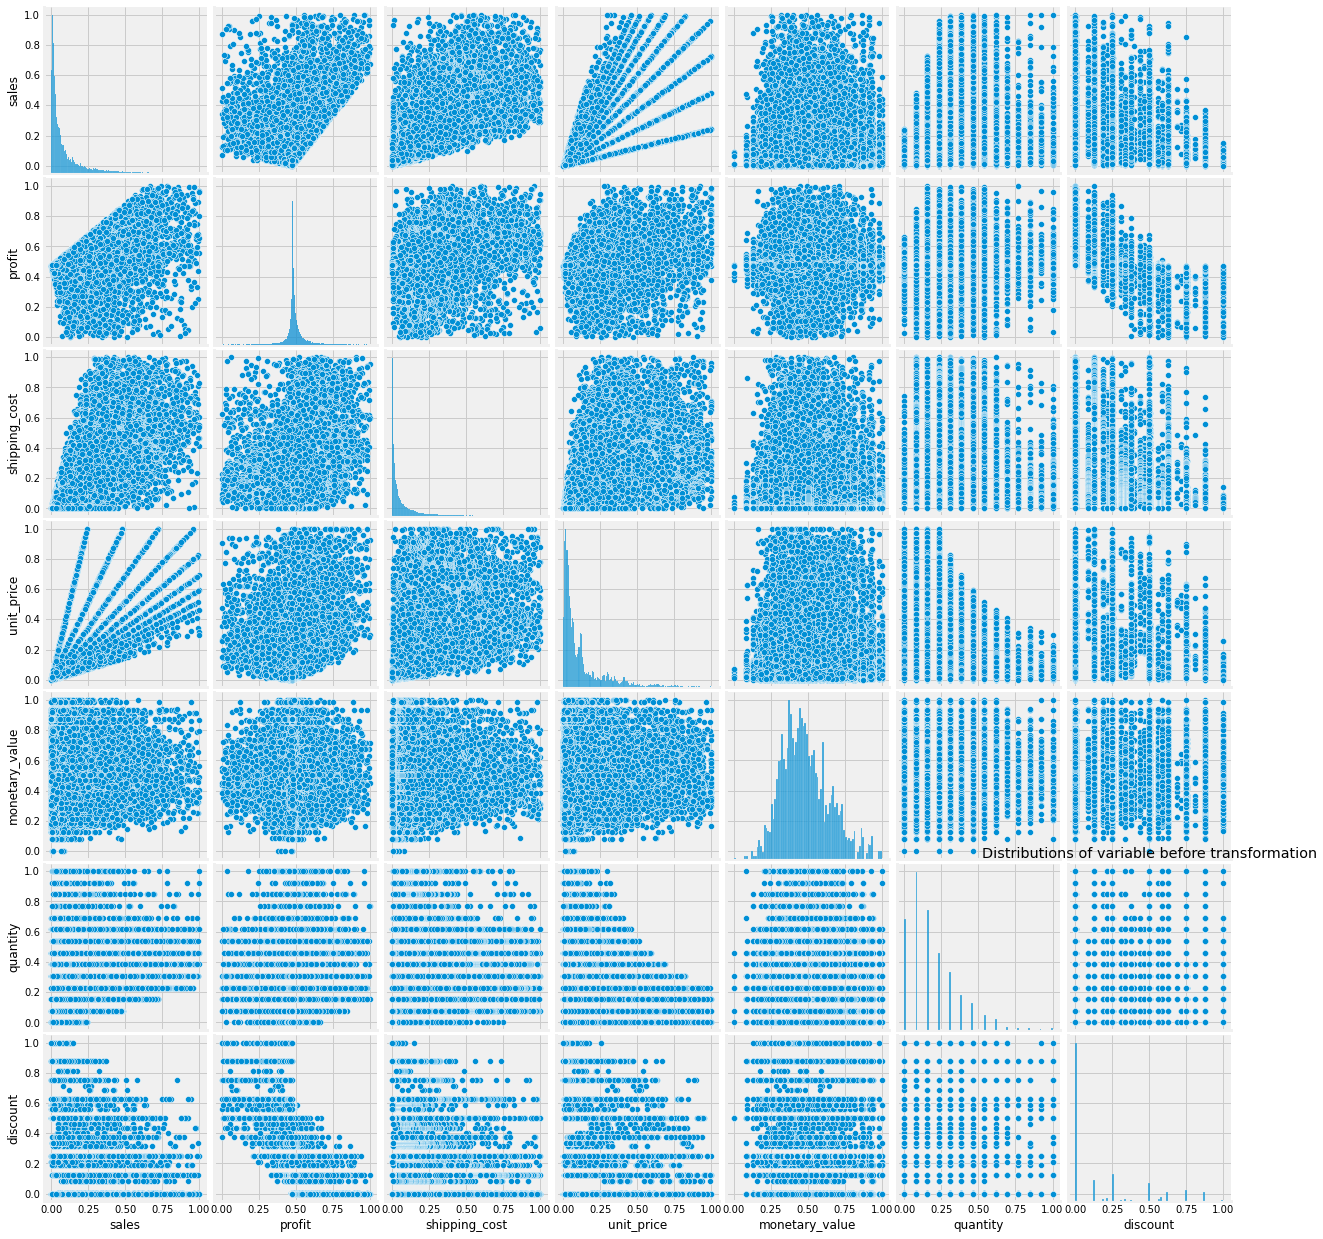

In [34]:
# view pairplot to see relations and view distributions of these numerical variables
print("Distributions of variable before transformation")
sns.pairplot(trx_num_ss)
plt.show()

- Skewed distributions for almost all except `profit`. I apply box-cox to try and normalize these distributions before regressing. 

In [35]:
# apply box-cox transformation on all features so it's more normally distributed
pt = PowerTransformer(method = 'box-cox')
# add constant to make data postiive
trx_num_ss = trx_num_ss+1
# fit and transform
trx_num_ss_bc = pt.fit_transform(trx_num_ss)
# convert to dataframe
trx_num_ss_bc = pd.DataFrame(trx_num_ss_bc, columns = trx_num_ss.columns)

In [36]:
trx_num_ss_bc.head()

,sales,profit,shipping_cost,unit_price,monetary_value,quantity,discount
0,0.868595,0.544639,1.515412,1.333734,1.532965,-0.599128,-0.814112
1,1.336000,0.452437,1.034980,1.679982,1.532965,-0.599128,-0.814112
2,-0.609662,-0.160419,0.111247,0.403275,1.532965,-1.479945,0.896476
3,-1.054462,-0.170614,-0.657314,-1.142946,1.532965,0.060337,-0.814112
4,-1.139566,-0.260528,-0.991448,-1.125593,1.532965,-0.599128,0.896476


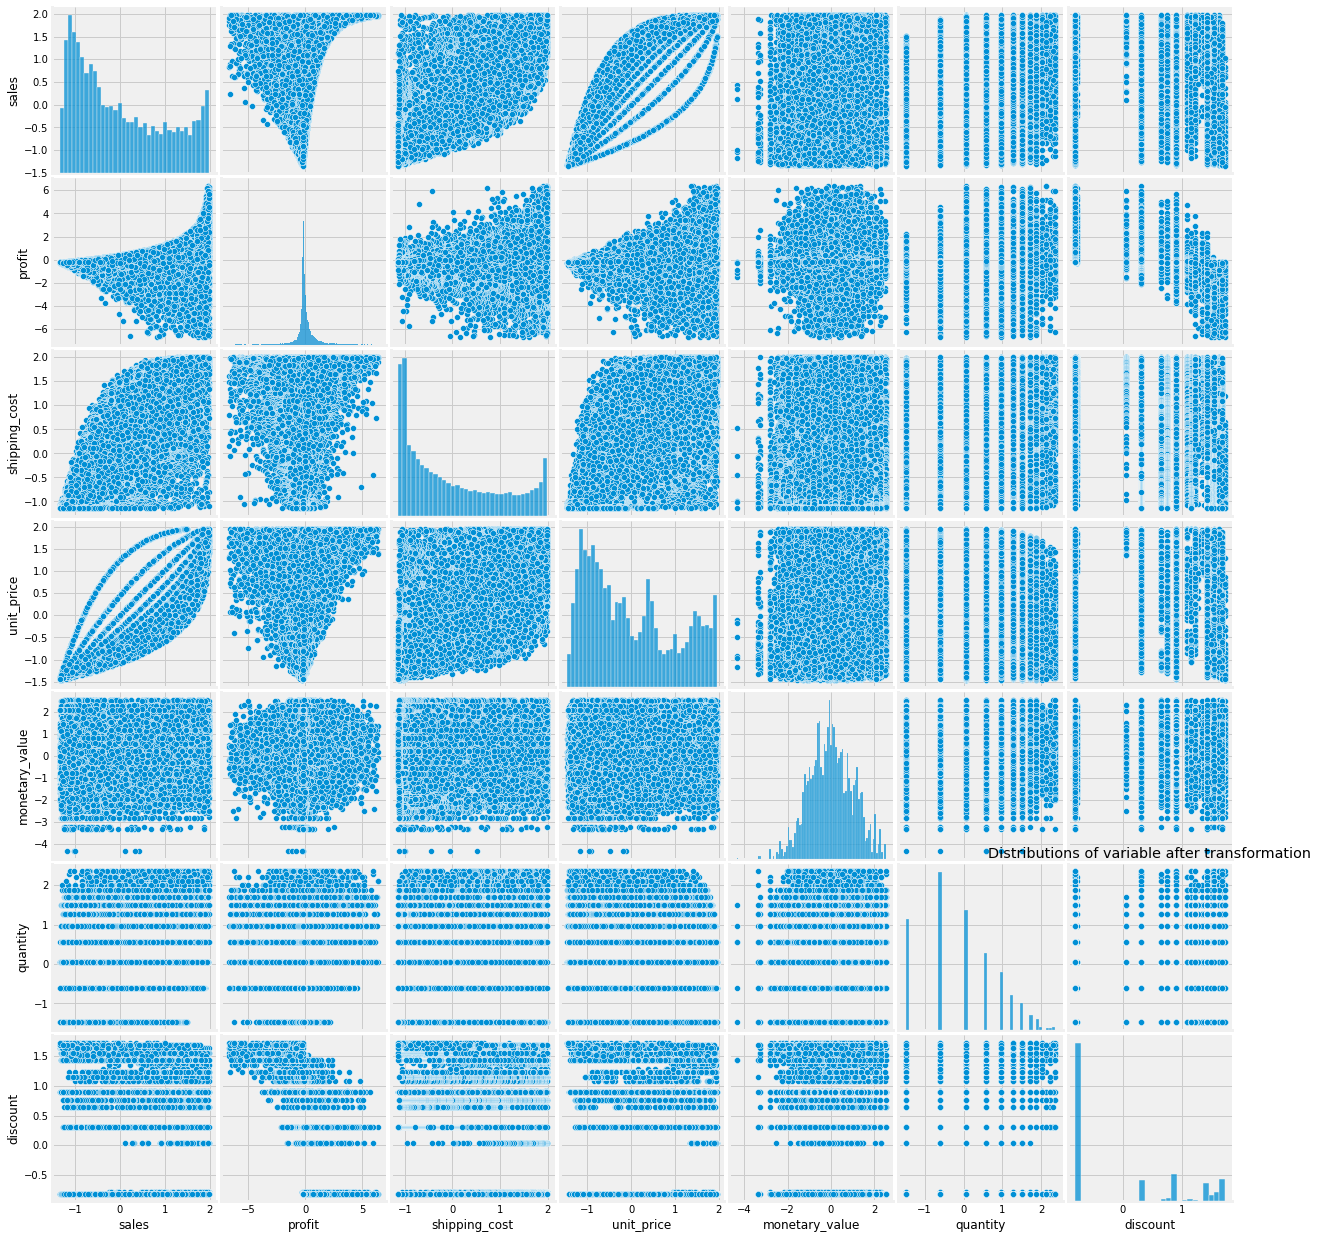

In [37]:
# view distributions after transformation
print("Distributions of variables after box-cox transformation")
sns.pairplot(trx_num_ss_bc)
plt.show()

- Distributions are more Gaussian

In [38]:
# merge with categorical var
trx_processed = pd.concat([trx_num_ss_bc, trx_cat], axis=1)
#preview data 
trx_processed.head()

,sales,profit,shipping_cost,unit_price,monetary_value,quantity,discount,heavy_discount,heavy_discount_regions,non_profitable,non_profitable_regions,more_qty,more_qty_regions,recency,frequency,category_Furniture,category_Office Supplies,category_Technology,ship_mode_First Class,ship_mode_Same Day,ship_mode_Second Class,ship_mode_Standard Class,region_Canada,region_Caribbean,region_Central Africa,region_Central America,region_Central Asia,region_Central US,region_Eastern Africa,region_Eastern Asia,region_Eastern Europe,region_Eastern US,region_North Africa,region_Northern Europe,region_Oceania,region_South America,region_Southeastern Asia,region_Southern Africa,region_Southern Asia,region_Southern Europe,region_Southern US,region_Western Africa,region_Western Asia,region_Western Europe,region_Western US,segment_Consumer,segment_Corporate,segment_Home Office,market_Africa,market_Asia Pacific,market_Europe,market_LATAM,market_USCA,order_priority_Critical,order_priority_High,order_priority_Low,order_priority_Medium,cluster
0,0.868595,0.544639,1.515412,1.333734,1.532965,-0.599128,-0.814112,0,0,0,0,0,1,16,89,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1
1,1.336000,0.452437,1.034980,1.679982,1.532965,-0.599128,-0.814112,0,0,0,0,0,1,16,89,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1
2,-0.609662,-0.160419,0.111247,0.403275,1.532965,-1.479945,0.896476,0,0,0,0,0,1,16,89,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1
3,-1.054462,-0.170614,-0.657314,-1.142946,1.532965,0.060337,-0.814112,0,0,0,0,1,1,16,89,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0
4,-1.139566,-0.260528,-0.991448,-1.125593,1.532965,-0.599128,0.896476,0,0,1,0,0,1,16,89,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1


In [42]:
# view correlation
corr_matrix = trx_processed.corr()
corr_matrix['sales'].sort_values(ascending = False)

sales                       1.000000
shipping_cost               0.897290
unit_price                  0.874017
quantity                    0.388510
category_Technology         0.369813
more_qty                    0.326790
profit                      0.318865
category_Furniture          0.285877
more_qty_regions            0.136154
market_Europe               0.098704
region_Western Europe       0.089147
region_Eastern Asia         0.068234
region_Oceania              0.055596
monetary_value              0.050394
market_Asia Pacific         0.049866
region_Southern Europe      0.048279
region_Southern Asia        0.040477
region_Southeastern Asia    0.035949
region_Northern Europe      0.032230
ship_mode_Standard Class    0.021144
order_priority_Medium       0.013561
region_Central America      0.006141
segment_Corporate           0.003819
order_priority_Low          0.002581
market_LATAM                0.000466
frequency                  -0.000690
segment_Consumer           -0.001326
o

### Model Prep 
Create features and target variable. In this case, I am predicting sales so `sales` is the target variable and everything else will be the features. Here I also split data into training and validation set.

In [39]:
# prep features and target variable
features = [col for col in trx_processed.columns if col != 'sales']
X = trx_processed[features]
y = trx_processed['sales']

In [40]:
# split data into training set and validation set 
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

### Feature Selection
I apply a stepwise selection algorithm to pick out the best features to predict sales for each cluster. Stepwise regression is done by selecting features one by one to ultimately find the optimal features to use. 

In [44]:
# instantiate linear regression for use in sequential feature selector
lr = LinearRegression()

In [45]:
# instantiate sequantial features selector
sfs = SequentialFeatureSelector(estimator = lr,
                               k_features = (10,30),
                               forward = True,
                               scoring = 'r2')

In [46]:
# fit train data into sfs
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(10, 30),
                          scoring='r2')

In [47]:
# print best score and features based on the score
print("======================== Best score obtained ========================")
print(round(sfs.k_score_,3))
print("==================== Features that contribute to the best score ====================")
print(sfs.k_feature_names_)

======================== Best score obtained ========================
0.969
==================== Features that contribute to the best score ====================
('profit', 'shipping_cost', 'unit_price', 'monetary_value', 'quantity', 'discount', 'heavy_discount', 'heavy_discount_regions', 'non_profitable', 'non_profitable_regions', 'more_qty', 'more_qty_regions', 'frequency', 'category_Technology', 'ship_mode_Second Class', 'ship_mode_Standard Class', 'region_Canada', 'region_Central Africa', 'region_Eastern Africa', 'region_Eastern Asia', 'region_Eastern Europe', 'region_Southern Asia', 'region_Western Africa', 'market_Africa', 'market_Europe', 'market_USCA', 'order_priority_Critical', 'order_priority_Medium', 'cluster')


A very good score of 0.969 based on the features selected above. This is means that with the above features selected, the model is able to account for 96.9% of variability of data. 

In [48]:
#transform the train and test sets
X_train_sfs = sfs.transform(X_train)
X_val_sfs = sfs.transform(X_val)

### Modelling
Run on models - ElasticNetCV, RandomForestRegressor, AdaBoostRegressor and XGBoost.

In [58]:
# baseline models
def baseline_model():
    '''function creates baseline models'''
    p1= Pipeline([
        ('enet', ElasticNetCV())
    ])
    p2 = Pipeline([
        ('rfr', RandomForestRegressor())
    ])
    p3 = Pipeline([
        ('adar', AdaBoostRegressor())
    ])
    p4 = Pipeline([
        ('xgbr', xgb.XGBRegressor())
    ])
    
    names = ['Elastic Net CV', 'Random Forest Regressor', 'AdaBoost Regressor', 'XGB Regressor']
    pipes = [p1, p2, p3, p4]
    
    print("Getting results for baseline models...")
    base_table = PrettyTable(title = f'R-square Score of Baseline', header_style = 'title', max_table_width = 110)
    base_table.field_names = ['Model', 'Train Set', 'Validation Set', 'Extent of Overfit'] 
        
    for i in range(len(names)):
        print()
        gs = GridSearchCV(pipes[i], param_grid = {}, n_jobs = -1)
        gs.fit(X_train_sfs, y_train)
        y_pred_train = gs.predict(X_train_sfs)
        y_pred_val = gs.predict(X_val_sfs)
        # add to table
        base_table.add_row([f'{names[i]}', round(r2_score(y_train, y_pred_train),3), round(r2_score(y_val, y_pred_val),3), (round(r2_score(y_train, y_pred_train),3)-round(r2_score(y_val, y_pred_val),3))])
        
    print(base_table)     

In [59]:
%%time
baseline_model()

Getting results for baseline models...




+------------------------------------------------------------------------------+
|                          Accuracy Score of Baseline                          |
+-------------------------+-----------+----------------+-----------------------+
|          Model          | Train Set | Validation Set |   Extent Of Overfit   |
+-------------------------+-----------+----------------+-----------------------+
|      Elastic Net CV     |   0.969   |     0.969      |          0.0          |
| Random Forest Regressor |    1.0    |      1.0       |          0.0          |
|    AdaBoost Regressor   |   0.953   |     0.953      |          0.0          |
|      XGB Regressor      |    1.0    |     0.999      | 0.0010000000000000009 |
+-------------------------+-----------+----------------+-----------------------+
Wall time: 38 s


- Best performing model is `RandomForestRegressor`. While `XGBoost` has an equally strong R2 score, there is some overfit. 
- Move forward with `RandomForestRegressor`

In [64]:
# using the model, predict on whole dataset and append to dataframe 
rfr = RandomForestRegressor()
rfr.fit(X_train_sfs, y_train)
#get predictions
y_pred = rfr.predict(sfs.transform(X))
y_pred = pd.DataFrame(y_pred, columns = ['predicted_sales'])

In [65]:
y_pred.head()

,predicted_sales
0,0.868772
1,1.336300
2,-0.609885
3,-1.054572
4,-1.139455


### Save data
Once predicted sales based on the best model, I then append the data to a column in original dataframe, for use in the next stage of the project. 

In [ ]:
# to be updated

### References (to be updated and formatted correctly.


for different models of regression use grid searchcv for tuning of hyper parameters.
https://towardsdatascience.com/predictive-modellers-guide-to-choosing-the-best-fit-regression-model-707120e502b4

has drawback for each kind of regression model 
https://medium.com/@mukul04.sk/how-to-choose-the-best-regression-model-for-your-ml-application-d1e60d6a98ad